In [15]:
print("""
This session consists of:

total duration: 4min 15s 

actions: 

5s      - rest   
5s      - 1min     : pinch #1 every ~one second  
1min    - 1min 5s  : rest   
1min 5s - 2min     : pinch #2 every ~one second   
2min    - 2min 5s  : rest   
2min 5s - 3min     : pinch #1 HOLD every ~one second   
3min    - 3min 5s  : rest   
3min 5s - 4min     : pinch #2 HOLD every ~one second   
4min    - 4min 15s : rest  
""")


This session consists of:

total duration: 4min 15s 

actions: 

5s      - rest   
5s      - 1min     : pinch #1 every ~one second  
1min    - 1min 5s  : rest   
1min 5s - 2min     : pinch #2 every ~one second   
2min    - 2min 5s  : rest   
2min 5s - 3min     : pinch #1 HOLD every ~one second   
3min    - 3min 5s  : rest   
3min 5s - 4min     : pinch #2 HOLD every ~one second   
4min    - 4min 15s : rest  



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
path = Path("../data/raw/session_1.txt")

In [3]:
df = pd.read_csv(path, comment="%", skip_blank_lines=True)

In [4]:
df.head()

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,Accel Channel 0,Accel Channel 1,Accel Channel 2,Other,Other.1,Other.2,Other.3,Other.4,Timestamp,Marker Channel,Timestamp (Formatted)
0,13.0,52.766248,206.416298,239.088064,212.026148,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.764951e+09,0.0,2025-12-05 16:07:39.205
1,13.0,-110.358838,46.563624,422.298283,7.403132,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.764951e+09,0.0,2025-12-05 16:07:39.205
2,0.0,-324.062331,-231.393220,-154.431689,-225.123278,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.764951e+09,0.0,2025-12-05 16:07:39.235
3,1.0,-266.793243,-218.643901,-222.997145,-248.207810,0.0,-0.032,0.0,0.0,0.0,0.0,0.0,0.0,1.764951e+09,0.0,2025-12-05 16:07:39.246
4,1.0,-395.902069,-154.270873,-109.455652,-97.914321,0.0,-0.032,0.0,0.0,0.0,0.0,0.0,0.0,1.764951e+09,0.0,2025-12-05 16:07:39.246


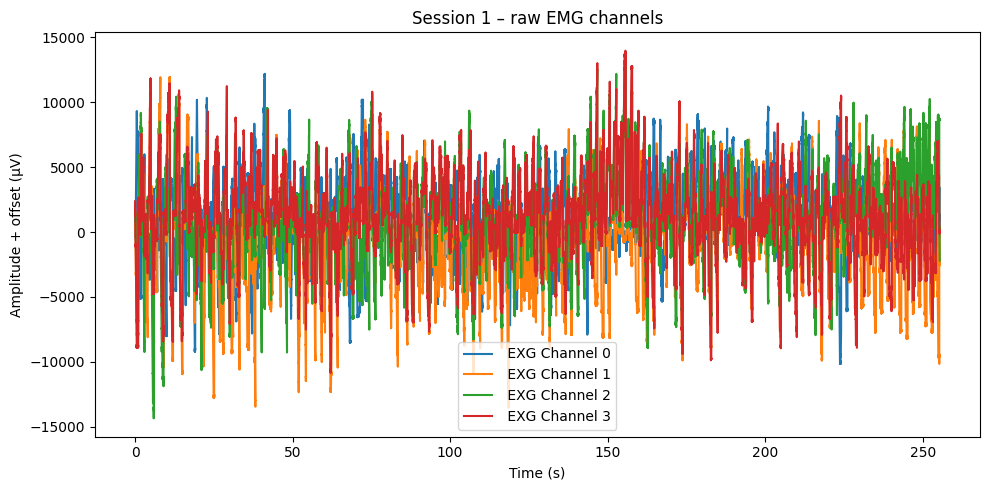

In [39]:
fs = 200  # sampling frequency; Hz
t = np.arange(len(df)) / fs

ch_names = [
    " EXG Channel 0",  # EXG: “excitatory” / “external biopotential” channels; OpenBCI label
    " EXG Channel 1",
    " EXG Channel 2",
    " EXG Channel 3",
]

plt.figure(figsize=(10,5))
offset = 0
for name in ch_names:
    plt.plot(t, df[name] + offset, label=name)
    offset += 500

plt.xlabel("Time (s)")
plt.ylabel("Amplitude + offset (µV)")
plt.title("Session 1 – raw EMG channels")
plt.legend()
plt.tight_layout()
plt.show()

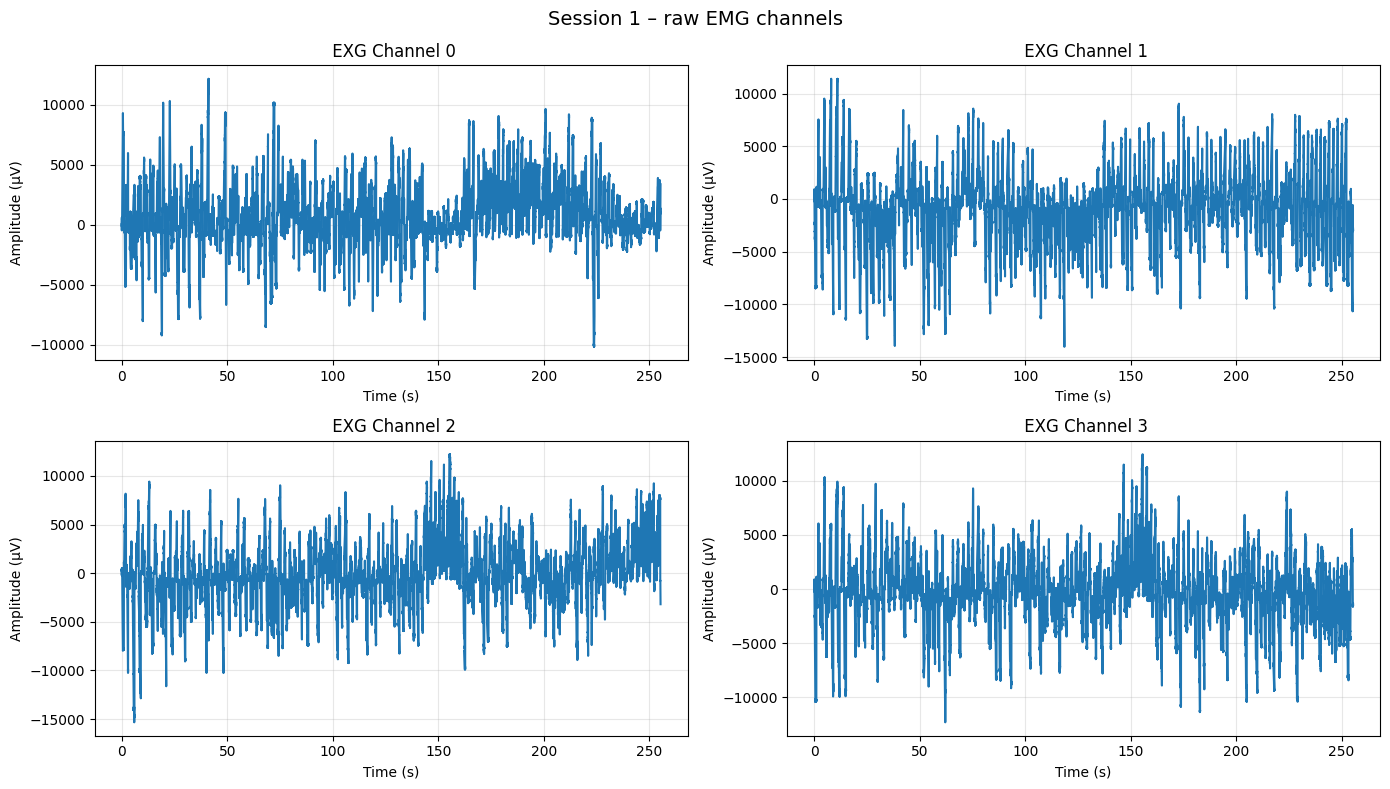

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, name in enumerate(ch_names):
    axes[i].plot(t, df[name])
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Amplitude (µV)")
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)

fig.suptitle("Session 1 – raw EMG channels", fontsize=14)
plt.tight_layout()
plt.show()

### Add gesture labels based on the timings described above

In [7]:
fs = 200.0
n_samples = len(df)

# time vector: one time stamp per sample, in seconds
t = np.arange(n_samples) / fs

labels = np.full(n_samples, "rest", dtype=object)

In [8]:
def mark_interval(start_s: float, end_s: float, name: str):
    idx = (t >= start_s) & (t < end_s)
    labels[idx] = name

In [9]:
# Timings (in seconds) from Session 1
mark_interval(5, 60, "pinch1")
mark_interval(60, 65, "rest")
mark_interval(65, 120, "pinch2")
mark_interval(120, 125, "rest")
mark_interval(125, 180, "pinch1_hold")
mark_interval(180, 185, "rest")
mark_interval(185, 240, "pinch2_hold")
mark_interval(240, 255, "rest")

In [10]:
df["label"] = labels

In [11]:
# see how many samples we have of each class
df["label"].value_counts()

label
pinch1         11000
pinch2         11000
pinch1_hold    11000
pinch2_hold    11000
rest            7087
Name: count, dtype: int64

In [12]:
# mean absolute EMG per label and channel
ch_names = [
    " EXG Channel 0",
    " EXG Channel 1",
    " EXG Channel 2",
    " EXG Channel 3",
]

feature_by_label = (df.groupby("label")[ch_names].apply(lambda x: x.abs().mean()))
feature_by_label

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3
label,,,,
pinch1,2233.641567,3468.579792,2875.089133,2649.141793
pinch1_hold,1933.525468,2680.970260,2895.355766,2731.104556
pinch2,2227.838740,2825.359195,2625.253102,2351.868797
pinch2_hold,2337.883570,2654.501539,2096.583237,2409.930480
rest,1593.759833,3807.401579,2806.550521,2875.326334


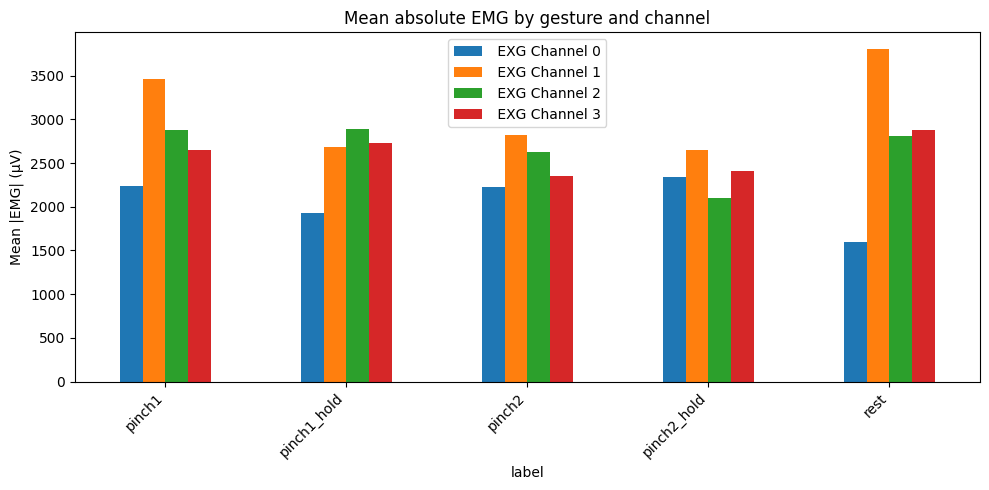

In [13]:
ax = feature_by_label.plot(kind="bar", figsize=(10, 5))
ax.set_ylabel("Mean |EMG| (µV)")  # average absolute amplitude
ax.set_title("Mean absolute EMG by gesture and channel")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Build sliding-window RMS features (one feature per channel per window)
`Output: win_df with columns [t_center, rms_ch0..3, label]`

In [22]:
# window params
win_s = 0.200
hop_s = 0.050  # 50ms hop (so we get an envelope update 20x/second)

win = int(round(win_s * fs))  # samples per window
hop = int(round(hop_s * fs))  # samples between windows

In [23]:
n = len(df)
starts = np.arange(0, n - win + 1, hop)  # start indicies for each window

In [25]:
rows = []
for s in starts:
    e = s + win  # window end index (exclusive)
    seg = df[ch_names].iloc[s:e].to_numpy()  # shape: (win, 4)

    # RMS per channel
    rms = np.sqrt(np.mean(seg**2, axis=0))

    center = s + win // 2  # center sample index (for time + label)
    rows.append({
        "t_center": center / fs,
        "rms_ch0": float(rms[0]),
        "rms_ch1": float(rms[1]),
        "rms_ch2": float(rms[2]),
        "rms_ch3": float(rms[3]),
        "label": df["label"].iloc[center],  # label at the window center
    })

win_df = pd.DataFrame(rows)

In [26]:
win_df["label"].value_counts()

label
pinch1         1100
pinch2         1100
pinch1_hold    1100
pinch2_hold    1100
rest            705
Name: count, dtype: int64

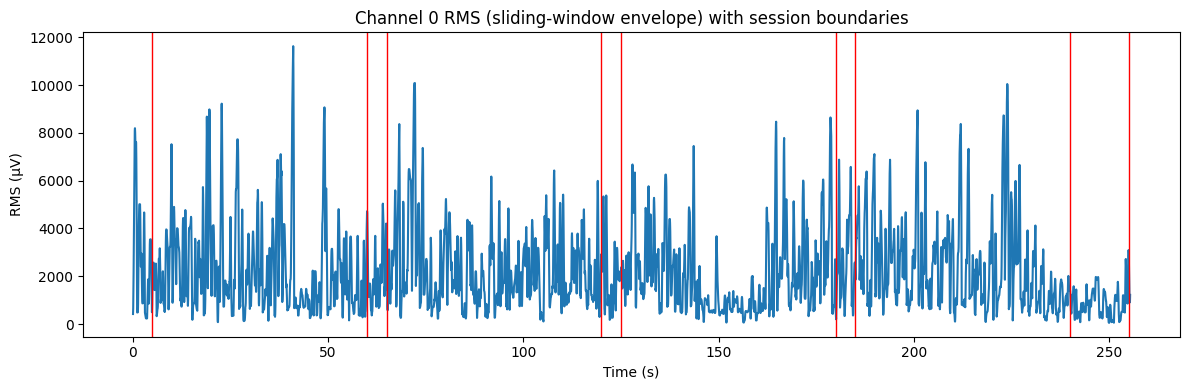

In [33]:
# plot RMS over time + show where the gesture blocks are

boundaries = [5, 60, 65, 120, 125, 180, 185, 240, 255]

plt.figure(figsize=(12, 4))
plt.plot(win_df["t_center"], win_df["rms_ch0"])  # RMS envelope for channel 0
for b in boundaries:
    plt.axvline(b, linewidth=1, color="red")  # segment boundary marker

plt.title("Channel 0 RMS (sliding-window envelope) with session boundaries")
plt.xlabel("Time (s)")
plt.ylabel("RMS (µV)")
plt.tight_layout()
plt.show()

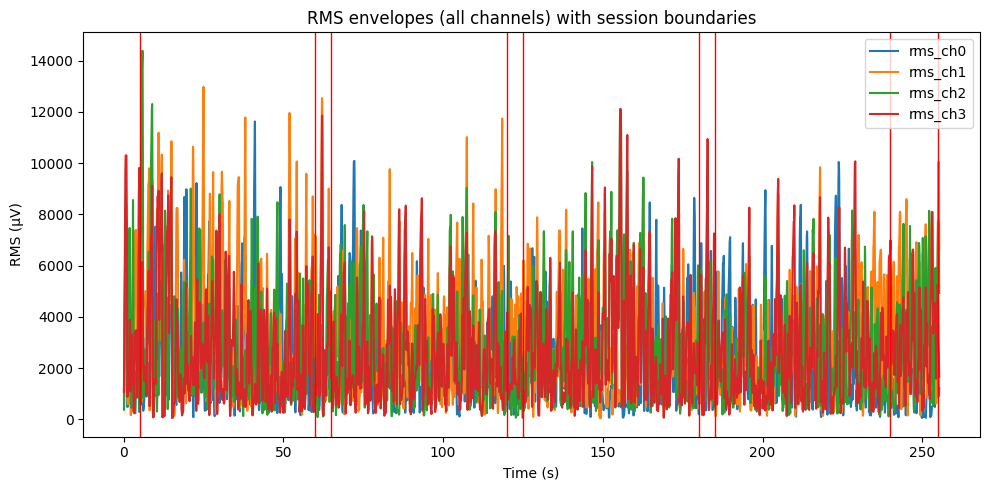

In [38]:
# plotting RMS envelopes for all 4 channels, with session boundaries
# (helps us see which channels light up for which gesture blocks)

plt.figure(figsize=(10, 5))
plt.plot(win_df["t_center"], win_df["rms_ch0"], label="rms_ch0")  # channel 0 envelope
plt.plot(win_df["t_center"], win_df["rms_ch1"], label="rms_ch1")  # channel 1 envelope
plt.plot(win_df["t_center"], win_df["rms_ch2"], label="rms_ch2")  # channel 2 envelope
plt.plot(win_df["t_center"], win_df["rms_ch3"], label="rms_ch3")  # channel 3 envelope

for b in boundaries:
    plt.axvline(b, linewidth=1, color="red")

plt.title("RMS envelopes (all channels) with session boundaries")
plt.xlabel("Time (s)")
plt.ylabel("RMS (µV)")
plt.legend()
plt.tight_layout()
plt.show()

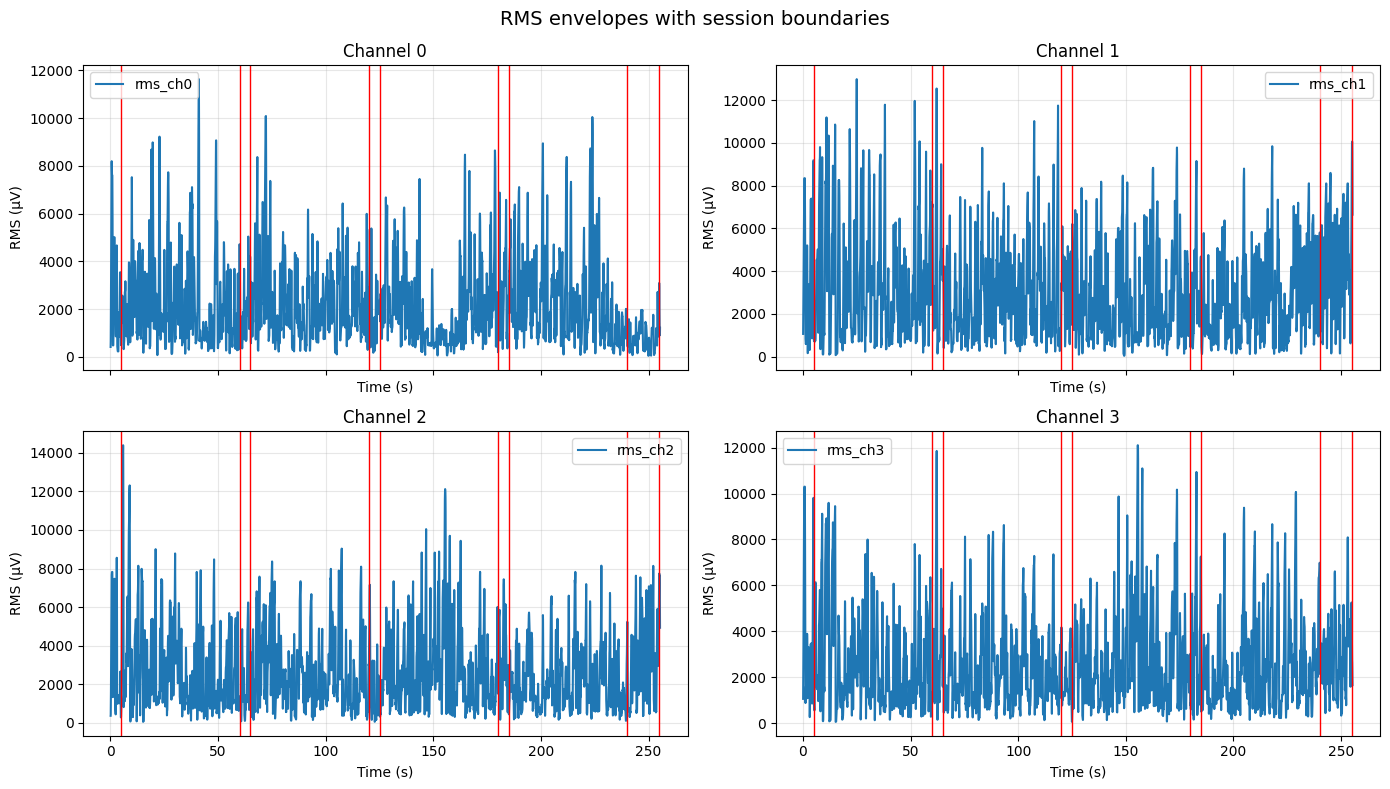

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
axes = axes.flatten()

channels = ["rms_ch0", "rms_ch1", "rms_ch2", "rms_ch3"]

for i, ch in enumerate(channels):
    axes[i].plot(win_df["t_center"], win_df[ch], label=ch)
    
    for b in boundaries:
        axes[i].axvline(b, linewidth=1, color="red")
    
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("RMS (µV)")
    axes[i].set_title(f"Channel {i}")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

fig.suptitle("RMS envelopes with session boundaries", fontsize=14)
plt.tight_layout()
plt.show()

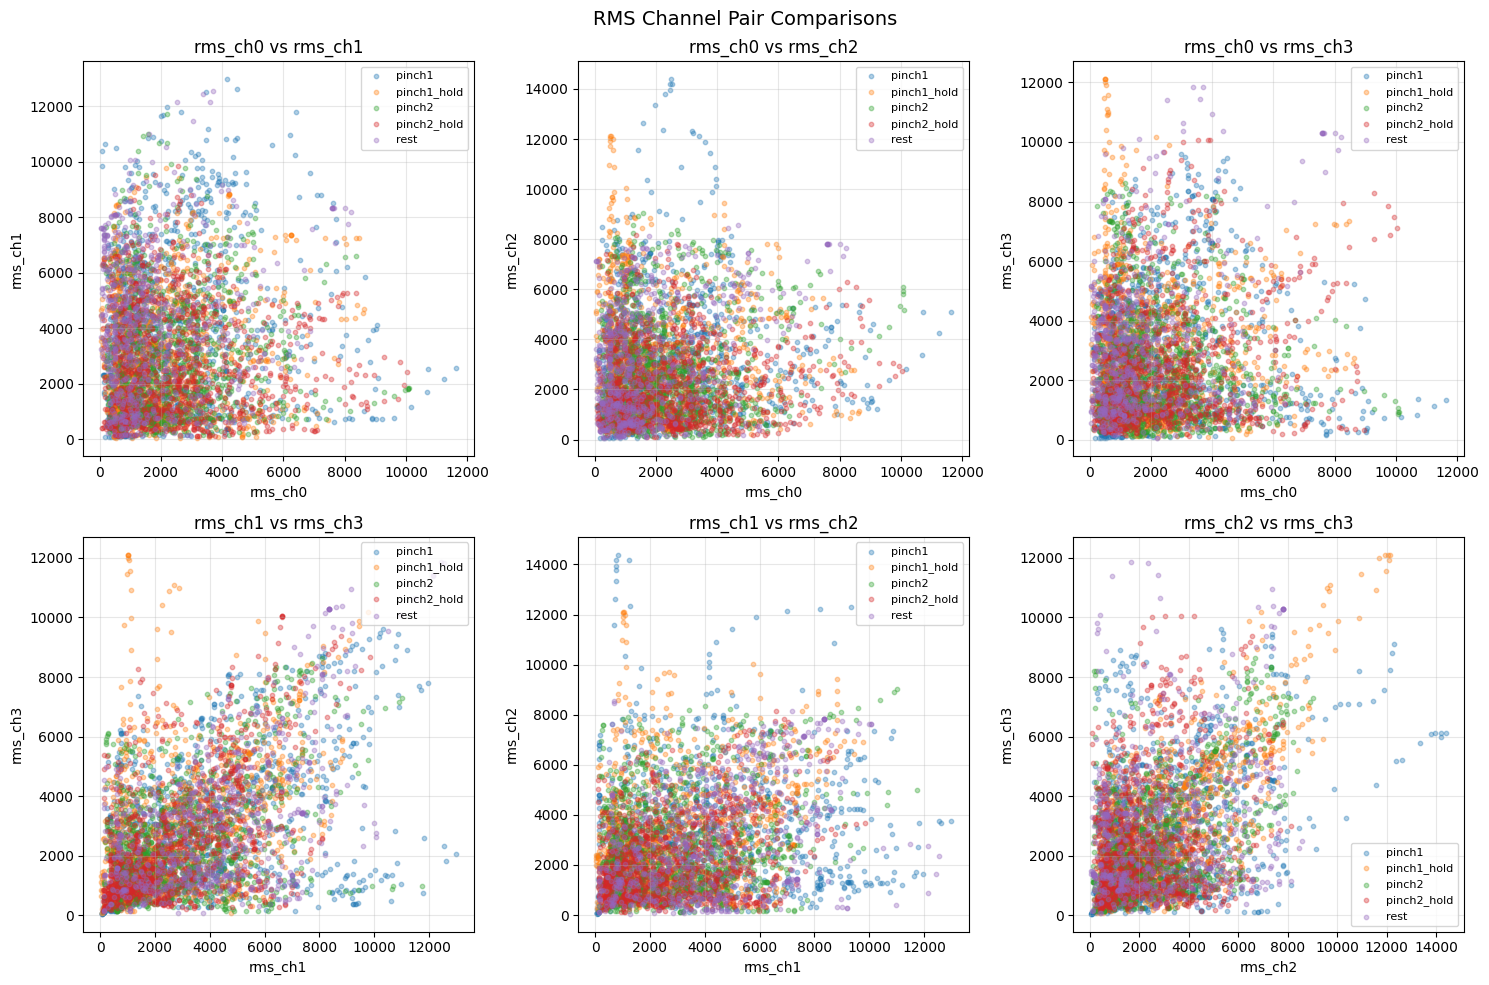

In [49]:
pairs = [
    ("rms_ch0", "rms_ch1"),
    ("rms_ch0", "rms_ch2"),
    ("rms_ch0", "rms_ch3"),
    ("rms_ch1", "rms_ch3"),
    ("rms_ch1", "rms_ch2"),
    ("rms_ch2", "rms_ch3"),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

labels = sorted(win_df["label"].unique())

for idx, (xcol, ycol) in enumerate(pairs):
    plot_df = win_df[[xcol, ycol, "label"]].dropna()
    
    for lab in labels:
        sub = plot_df[plot_df["label"] == lab]
        # optional: subsample to reduce overplotting
        if len(sub) > 3000:
            sub = sub.sample(3000, random_state=0)
        axes[idx].scatter(sub[xcol], sub[ycol], s=10, alpha=0.35, label=lab)
    
    axes[idx].set_xlabel(xcol)
    axes[idx].set_ylabel(ycol)
    axes[idx].set_title(f"{xcol} vs {ycol}")
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

fig.suptitle("RMS Channel Pair Comparisons", fontsize=14)
plt.tight_layout()
plt.show()